In [1]:
import numpy as np, tensorflow as tf, pandas as pd
import keras, sklearn, pickle
from keras.preprocessing import text, sequence
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model("bidirectional-gru.hdf5")
graph = tf.get_default_graph()

with open('bidirectional-gru-tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [3]:
test = pd.read_csv("test.csv")
sub = pd.read_csv("submission.csv")

In [4]:
test["comment_text"] = test["comment_text"].apply(lambda x: 'shit ' + x)
X_test = test["comment_text"].str.lower()

In [5]:
seq=tokenizer.texts_to_sequences(X_test)
seq=sequence.pad_sequences(seq,maxlen=150)

with graph.as_default():
    y_pred = model.predict(seq,verbose=1)

153164/153164 [==============================] - 384s 3ms/step


In [6]:
del sub['id']
sub = sub.values
y_pred = y_pred - sub
print(y_pred[0:5])

[[ 8.58664513e-04 -6.31588697e-03  4.56005335e-03  4.37411018e-01
  -6.11864328e-02  4.63219821e-01]
 [ 9.23717415e-01  3.26879350e-02  9.53271407e-01  4.31944775e-04
   2.20138416e-01  6.90935960e-03]
 [ 9.03789118e-01  3.44648776e-02  9.38447538e-01  2.01935500e-03
   1.18967631e-01  2.45361161e-02]
 [ 7.63445293e-01  7.91855523e-03  8.68565275e-01  2.43481379e-04
   1.21662393e-01  2.39424010e-03]
 [ 9.27267591e-01  6.07868494e-02  9.62224854e-01  7.72124644e-04
   1.56827144e-01  1.64305161e-02]]


In [14]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sub_df = pd.DataFrame(sub, columns=labels)
diff = pd.DataFrame(y_pred, columns=labels)

In [8]:
import seaborn as sns
import matplotlib as plt

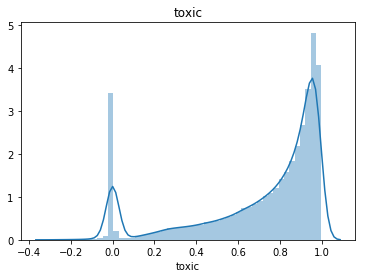

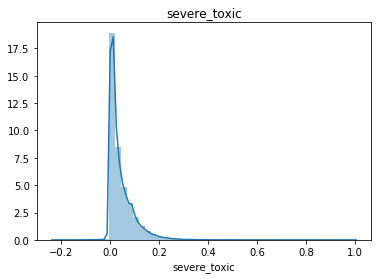

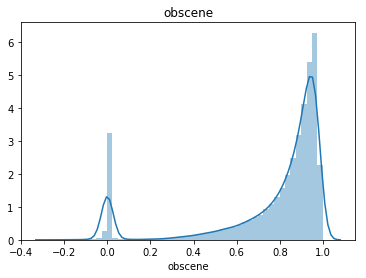

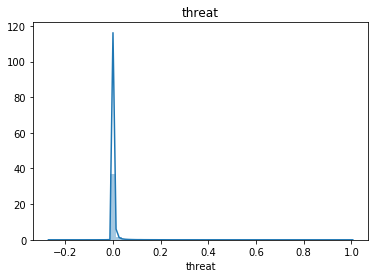

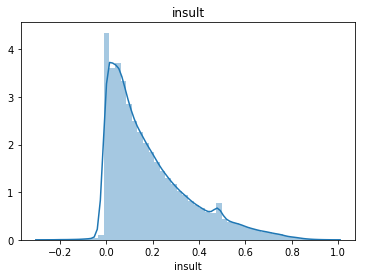

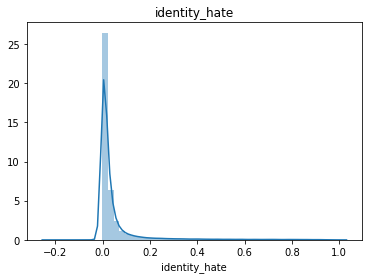

In [23]:
for l in labels:
    plt.pyplot.figure()
    plt.pyplot.title(l)
    
    s = sub_df[l]
    d = diff[l]
    
    #d = d[s < 0.25]
    s = s[s < 0.25]
    
    d = d / (1-s)
    d = d[d >= -1]
    sns.distplot(d)